In [1]:
import os
import pandas as pd
import warnings

from sklearn.model_selection import train_test_split, KFold

warnings.filterwarnings("ignore")

# ========== 配置 ==========
data_path = "整合数据/final_data_cleaned.xlsx"
target_cols = ["Mad", "Vad"] # 修改为两个目标
sample_col = "Sample"
output_base_dir = "integrated_outputs" # 统一的输出目录
os.makedirs(output_base_dir, exist_ok=True)


# ========== 读取数据 ==========
df_original = pd.read_excel(data_path)
exclude_cols = [sample_col, "Mad", "Vad"]
feature_cols = [c for c in df_original.columns if c not in exclude_cols and pd.api.types.is_numeric_dtype(df_original[c])]

# ========== 数据规模信息 ==========
print(f"原始数据维度: {df_original.shape}")

原始数据维度: (738, 128)


In [2]:

import os
import pandas as pd
import numpy as np
import shap
import dcor
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.auto import tqdm

from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.decomposition import NMF
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

warnings.filterwarnings("ignore")
# ========== 定义HSIC函数和Partial Corr函数 (保持不变) ==========
def hsic(x, y):
    x = (x - x.mean()) / x.std()
    y = (y - y.mean()) / y.std()
    K = np.outer(x, x)
    L = np.outer(y, y)
    H = np.eye(len(x)) - 1.0 / len(x)
    return np.trace(K @ H @ L @ H) / ((len(x) - 1) ** 2)

def partial_corr(X, y, idx):
    xi = X[:, idx]
    X_rest = np.delete(X, idx, axis=1)
    # 确保 X_rest 不为空
    if X_rest.shape[1] == 0:
        return spearmanr(xi, y)[0] # 如果没有其他特征，直接计算xi和y的相关性
    model_x = LinearRegression().fit(X_rest, xi)
    res_x = xi - model_x.predict(X_rest)
    model_y = LinearRegression().fit(X_rest, y)
    res_y = y - model_y.predict(X_rest)
    rho, _ = spearmanr(res_x, res_y)
    return rho

# ========== 融合评价函数 (原第二段代码) ==========
# 1. 平滑度 & 成段性指标
def smoothness_score(curve):
    tv = np.sum(np.abs(np.diff(curve)))
    return 1 / (1 + tv)

def segmentation_score(curve, window_size=10):
    energy_total = np.sum(curve**2)
    if energy_total == 0:
        return 0
    max_ratio = 0
    for i in range(len(curve) - window_size + 1):
        window_energy = np.sum(curve[i:i+window_size]**2)
        ratio = window_energy / energy_total
        if ratio > max_ratio:
            max_ratio = ratio
    return max_ratio

# --- 三个指标加权融合
def compute_final_weights(results_df, weights=None, dynamic_alpha=0.3, softmax_tau=5.0):
    """
    根据三个指标结果动态分配融合权重：
    - 如果传入 weights(dict)，则使用显式权重（与原逻辑一致）。
    - 否则采用“标准差 → Softmax → 与均匀分布平滑”方案，避免权重差距过大。

    参数：
    - dynamic_alpha: 与均匀分布的平滑系数，越小越接近均匀，默认 0.3。
    - softmax_tau: Softmax 温度（越大越平滑、差距越小），默认 5.0。
    """
    cols = ["NMF_Weight", "Smoothness", "Segmentation"]

    if weights is not None:
        total = sum(weights.values())
        weights = {k: v/total for k, v in weights.items()}
        # 保存归一化后的显式权重
        w_consistency = weights.get("NMF_Weight", 0.0)
        w_smoothness = weights.get("Smoothness", 0.0)
        w_segmentation = weights.get("Segmentation", 0.0)

        results_df["Final_Weight"] = (
            w_consistency * results_df["NMF_Weight"] +
            w_smoothness * results_df["Smoothness"] +
            w_segmentation * results_df["Segmentation"]
        )
        # 将权重与加权后的分量保存到结果中（每行相同，便于后续绘图）
        results_df["Weight_Consistency"] = w_consistency
        results_df["Weight_Smoothness"] = w_smoothness
        results_df["Weight_Segmentation"] = w_segmentation
        results_df["NMF_Weight_Weighted"] = results_df["NMF_Weight"] * w_consistency
        results_df["Smoothness_Weighted"] = results_df["Smoothness"] * w_smoothness
        results_df["Segmentation_Weighted"] = results_df["Segmentation"] * w_segmentation
    else:
        # 1) 指标的“可分性”：使用列标准差衡量（越大说明区分能力越强）
        stds = results_df[cols].std().values.astype(float)
        eps = 1e-12
        stds = stds + eps

        # 2) Softmax（带温度）得到动态权重，避免极端值
        w_dyn = np.exp(stds / max(softmax_tau, eps))
        w_dyn = w_dyn / w_dyn.sum()

        # 3) 与均匀分布做凸组合，限制差距不要太大
        uniform = np.ones_like(w_dyn) / len(w_dyn)
        w_final = (1.0 - dynamic_alpha) * uniform + dynamic_alpha * w_dyn
        # 拆解三个指标的最终权重
        w_consistency, w_smoothness, w_segmentation = float(w_final[0]), float(w_final[1]), float(w_final[2])

        # 4) 应用到每个方法上：加权求和得到最终融合分数
        results_df["Final_Weight"] = results_df[cols].values @ w_final
        # 将权重与加权后的分量保存到结果中（每行相同，便于后续绘图）
        results_df["Weight_Consistency"] = w_consistency
        results_df["Weight_Smoothness"] = w_smoothness
        results_df["Weight_Segmentation"] = w_segmentation
        results_df["NMF_Weight_Weighted"] = results_df["NMF_Weight"] * w_consistency
        results_df["Smoothness_Weighted"] = results_df["Smoothness"] * w_smoothness
        results_df["Segmentation_Weighted"] = results_df["Segmentation"] * w_segmentation

    # 归一化，避免除以零
    total_fw = results_df["Final_Weight"].sum()
    if total_fw != 0:
        results_df["Final_Weight"] /= total_fw
    return results_df

# 2. 综合评价函数
def evaluate_methods(df_scores, df_ranks, window_size=10, output_dir="融合结果"):
    wavelengths = df_scores["Wavelength"].values
    methods = df_scores.columns[1:]

    # --- 数据非负化（用于 NMF）
    X = df_scores[methods].values
    X_nonneg = X - X.min() + 1e-6

    # --- NMF 分解
    # 检查 X_nonneg 是否有足够的样本和特征
    if X_nonneg.shape[0] < 2 or X_nonneg.shape[1] < 2:
        print(f"警告: 数据维度不足 ({X_nonneg.shape})，无法进行 NMF 分解。跳过融合。")
        # 返回原始的第一个方法作为融合结果的替代，或抛出错误
        fused_curve = df_scores[methods[0]].values if len(methods) > 0 else np.zeros(len(wavelengths))
        fused_rank = pd.Series(fused_curve).rank(ascending=False, method="min").astype(int)
        
        scores_out = df_scores.copy()
        scores_out["Fused_Score"] = fused_curve
        ranks_out = df_ranks.copy()
        ranks_out["Fused_Rank"] = fused_rank
        
        os.makedirs(output_dir, exist_ok=True)
        scores_out.to_csv(os.path.join(output_dir, "scores_with_fused.csv"), index=False)
        ranks_out.to_csv(os.path.join(output_dir, "ranks_with_fused.csv"), index=False)
        
        plt.figure(figsize=(10, 4))
        plt.plot(wavelengths, fused_curve, color="red", label="Fused Curve (NMF Skipped)")
        plt.title("Final Integrated Importance Curve (NMF Skipped)")
        plt.savefig(os.path.join(output_dir, "fused_curve.png"), dpi=300)
        plt.close()

        plt.figure(figsize=(12, 2))
        heatmap_data = fused_curve.reshape(1, -1)
        plt.imshow(heatmap_data, aspect="auto", cmap="viridis",
                   extent=[wavelengths.min(), wavelengths.max(), 0, 1])
        plt.title("Fused Importance Heatmap (NMF Skipped)")
        plt.savefig(os.path.join(output_dir, "fused_heatmap.png"), dpi=300)
        plt.close()
        
        return scores_out, ranks_out, pd.DataFrame(), fused_curve, wavelengths

    nmf = NMF(n_components=1, init="nndsvd", random_state=0, max_iter=1000)
    W = nmf.fit_transform(X_nonneg)[:, 0]
    H = nmf.components_[0]
    # 方法贡献度（归一化）
    if H.sum() != 0:
        nmf_weights = H / H.sum()
    else:
        nmf_weights = np.ones_like(H) / len(H) # 避免除以零

    # --- 共识曲线归一化（仅用于相关性计算更稳定）
    consensus_curve = (W - W.min()) / (W.max() - W.min() + 1e-9)

    # --- 方法与共识曲线的相关性作为“权重”
    method_corr = {}
    for i, m in enumerate(methods):
        # 确保用于相关性计算的数组至少有两个元素
        if len(X_nonneg[:, i]) > 1 and len(consensus_curve) > 1:
            corr = np.corrcoef(X_nonneg[:, i], consensus_curve)[0, 1]
        else:
            corr = 0 # 如果数据不足，相关性设为0
        method_corr[m] = corr

    # 转成 Series
    method_corr = pd.Series(method_corr)

    # --- 平滑度和局部成段性
    scores = {}
    for i, m in enumerate(methods):
        curve = df_scores[m].values
        # 确保曲线可以归一化，避免除以零
        if curve.max() - curve.min() != 0:
            curve_norm = (curve - curve.min()) / (curve.max() - curve.min() + 1e-9)
        else:
            curve_norm = np.zeros_like(curve) # 如果曲线是常数，归一化为0
        scores[m] = {
            "NMF_Weight": method_corr[i],
            "Smoothness": smoothness_score(curve_norm),
            "Segmentation": segmentation_score(curve_norm, window_size)
        }

    results_df = pd.DataFrame(scores).T

    # --- 三个指标归一化
    for col in ["NMF_Weight", "Smoothness", "Segmentation"]:
        if results_df[col].sum() != 0: # 避免除以零
            results_df[col] = results_df[col] / results_df[col].sum()
        else:
            results_df[col] = 1.0 / len(results_df) # 平均分配

    # --- 最终融合权重
    results_df = compute_final_weights(results_df)

    # --- 得到最终融合曲线
    fused_curve = np.zeros(len(wavelengths))
    for m in methods:
        # 确保权重存在且为有效数字
        weight = results_df.loc[m, "Final_Weight"] if m in results_df.index and pd.notna(results_df.loc[m, "Final_Weight"]) else 0
        fused_curve += df_scores[m].values * weight

    # --- 融合后的排名
    fused_rank = pd.Series(fused_curve).rank(ascending=False, method="min").astype(int)

    # --- 输出两个文件
    os.makedirs(output_dir, exist_ok=True)

    scores_out = df_scores.copy()
    scores_out["Fused_Score"] = fused_curve
    scores_out.to_csv(os.path.join(output_dir, "scores_with_fused.csv"), index=False)

    ranks_out = df_ranks.copy()
    ranks_out["Fused_Rank"] = fused_rank
    ranks_out.to_csv(os.path.join(output_dir, "ranks_with_fused.csv"), index=False)

    # --- 绘制并保存折线图
    plt.figure(figsize=(10, 4))
    plt.plot(wavelengths, fused_curve, color="red", label="Fused Curve")
    plt.xlabel("Wavelength")
    plt.ylabel("Fused Importance")
    plt.title("Final Integrated Importance Curve")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "fused_curve.png"), dpi=300)
    plt.close()

    # --- 绘制并保存热力图
    plt.figure(figsize=(12, 2))
    heatmap_data = fused_curve.reshape(1, -1)
    plt.imshow(heatmap_data, aspect="auto", cmap="viridis",
               extent=[wavelengths.min(), wavelengths.max(), 0, 1])
    plt.colorbar(label="Importance")
    plt.xlabel("Wavelength")
    plt.yticks([])
    plt.title("Fused Importance Heatmap")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "fused_heatmap.png"), dpi=300)
    plt.close()

    print(f"✅ 已保存两个文件和两张图片到: {output_dir}")
    return scores_out, ranks_out, results_df, fused_curve, wavelengths


In [3]:

# ===============================================
# 预测模型训练与评估 (原第三段代码的修改)
# ===============================================

print("\n======== 开始预测模型训练与评估 ========\n")

# 所有模型 (与原第三段代码一致，但可以在这里调整)
models_prediction = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    # "ElasticNet": ElasticNet(alpha=0.01, l1_ratio=0.5),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "ExtraTrees": ExtraTreesRegressor(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=200, random_state=42),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "SVR": SVR(kernel="rbf", C=1.0, epsilon=0.1),
    "MLP": MLPRegressor(hidden_layer_sizes=(100,50), max_iter=500, random_state=42),
    "CatBoost": CatBoostRegressor(n_estimators=200, random_state=42, verbose=0),
}

# 定义用于模型评估的特征数量 (Top-N)
TOPN_LIST = {
    "Mad": list(range(50, 75, 5)), # 使用较小的范围以加快示例运行速度
    "Vad": list(range(50, 75, 5))
}

# 定义 TopN 列表
# TOPN_LIST = {
#     "Mad": [56, 64, 58, 66, 62, 68, 60, 74, 26, 54, 52, 70, 72, 50, 34],
#     "Vad": [70, 74, 80, 50, 54, 48, 56, 76, 42, 10, 8, 68, 6, 52, 64, 62, 44]
# }

# # 定义 TopN 列表
# TOPN_LIST = {
#     "Mad": [66, 62, 72, 64, 76, 68, 70, 54, 50, 58, 56, 60, 74, 48, 80, 52, 78, 44, 38, 46, 36, 34, 40, 26, 42, 32],
#     "Vad": [54, 60, 72, 64, 62, 58, 68, 78, 6, 80, 56, 76, 74, 70, 66, 48, 50, 42, 52, 10, 38, 8, 44, 12, 40]
# }

def run_experiment_prediction(target, df_train_data, df_test_data, ranks_df, topn_list):
    results = []
    
    # 准备训练集和测试集的 X 和 y
    X_train_full = df_train_data[feature_cols].values
    y_train_full = df_train_data[target].values
    X_test_full = df_test_data[feature_cols].values
    y_test_full = df_test_data[target].values

    methods_to_evaluate = [c for c in ranks_df.columns if c.endswith("_Rank")]

    for method in tqdm(methods_to_evaluate, desc=f"{target} Methods"):
        sorted_wavelengths = ranks_df.sort_values(by=method)["Wavelength"].values

        for model_name, model in tqdm(models_prediction.items(), desc=f"{target} Models ({method})", leave=False):
            row = {"Target": target, "Method": method.replace("_Rank",""), "Model": model_name}
            
            maes = []
            for N in topn_list:
                selected_wavelengths = sorted_wavelengths[:N]
                
                # 检查所有选择的波长是否存在于特征列中
                valid_selected_wavelengths = [w for w in selected_wavelengths if w in df_train_data.columns]
                
                if not valid_selected_wavelengths:
                    print(f"警告: 目标 {target}, 方法 {method}, N={N} 没有找到有效的波长特征。跳过。")
                    row[f"MAE-{N}"] = np.nan
                    continue

                # 从训练集和测试集DataFrame中选择特征
                X_train_selected = df_train_data[valid_selected_wavelengths].values
                X_test_selected = df_test_data[valid_selected_wavelengths].values

                # 在这里，我们不再需要内部的 train_test_split，因为我们已经有了 df_train_data 和 df_test_data
                # 而是直接使用 X_train_selected, y_train_full 进行训练
                # 和 X_test_selected, y_test_full 进行评估

                if X_train_selected.shape[0] == 0 or X_test_selected.shape[0] == 0:
                    print(f"警告: 目标 {target}, 方法 {method}, N={N} 的训练集或测试集为空。跳过。")
                    row[f"MAE-{N}"] = np.nan
                    continue

                model.fit(X_train_selected, y_train_full)
                y_pred = model.predict(X_test_selected)

                mae = mean_absolute_error(y_test_full, y_pred)
                row[f"MAE-{N}"] = mae
                maes.append(mae)

            # 额外加一列：所有 N 上的平均 MAE (忽略 NaN 值)
            row["MAE-mean"] = np.nanmean(maes) if maes else np.nan

            results.append(row)

    return pd.DataFrame(results)


======== 开始预测模型训练与评估 ========



In [4]:

# =======================
# K 折封装：每折运行完整流程（特征选择、融合、预测）
# =======================
def run_pipeline_for_fold(df_train, df_test, fold_idx):
    all_fused_results = {}

    # 特征选择与融合（针对每个目标变量）
    for current_target_col in tqdm(
        target_cols, desc=f"Fold {fold_idx+1} 目标变量", unit="target", dynamic_ncols=True, leave=False
    ):
        print(f"\n======== Fold {fold_idx+1}: 正在处理目标变量 {current_target_col} ========\n")

        # 获取训练集数据
        X_train_fs = df_train[feature_cols].values.astype(float)
        y_train_fs = df_train[current_target_col].values.astype(float)

        # 结果存储
        all_scores = {"Wavelength": feature_cols}
        all_ranks = {"Wavelength": feature_cols}

        # 方法 1: PLS (VIP)
        print("计算 PLS VIP ...")
        scaler_x, scaler_y = StandardScaler(), StandardScaler()
        X_scaled = scaler_x.fit_transform(X_train_fs)
        y_scaled = scaler_y.fit_transform(y_train_fs.reshape(-1, 1)).ravel()

        n_components = min(10, X_train_fs.shape[1], X_train_fs.shape[0] - 1)
        if n_components > 0:
            pls = PLSRegression(n_components=n_components)
            pls.fit(X_scaled, y_scaled)

            t = pls.x_scores_
            w = pls.x_weights_
            q = pls.y_loadings_
            if q.shape[0] > 1:
                q = np.sqrt((q ** 2).sum(axis=0))
            else:
                q = q.ravel()
            p, A = X_train_fs.shape[1], t.shape[1]
            s = np.array([(t[:, a] ** 2).sum() * (q[a] ** 2) for a in range(A)])
            if s.sum() != 0:
                vip = np.sqrt(p * ((w ** 2) @ s) / s.sum())
            else:
                vip = np.zeros(p)

            all_scores["PLS"] = vip
            all_ranks["PLS_Rank"] = pd.Series(vip).rank(ascending=False, method="min").astype(int)
        else:
            print("警告: 数据不足以进行PLS回归，PLS VIP计算跳过。")
            all_scores["PLS"] = np.zeros(len(feature_cols))
            all_ranks["PLS_Rank"] = pd.Series(np.zeros(len(feature_cols))).rank(ascending=False, method="min").astype(int)

        # 方法 2: 树模型 + SHAP
        print("计算 树模型 + SHAP ...")
        X_model_train, X_model_test, y_model_train, y_model_test = train_test_split(
            X_train_fs, y_train_fs, test_size=0.2, random_state=42
        )

        models_fs = {
            "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
            "XGBoost": XGBRegressor(n_estimators=200, random_state=42, verbosity=0),
            "LightGBM": LGBMRegressor(n_estimators=200, random_state=42, verbose=-1),
            "CatBoost": CatBoostRegressor(iterations=200, depth=6, learning_rate=0.1,
                                          random_state=42, verbose=0)
        }

        def compute_importance(name, model, X_used, y_train_subset):
            if name in ["RandomForest", "XGBoost", "LightGBM", "CatBoost"]:
                try:
                    if not hasattr(model, "tree_model") and not hasattr(model, "best_iteration_"):
                        model.fit(X_used, y_train_subset)
                    if hasattr(model, 'feature_importances_'):
                        explainer = shap.TreeExplainer(model)
                    else:
                        print(f"警告: 模型 {name} 不支持TreeExplainer或其内部结构不匹配，尝试使用KernelExplainer (较慢)。")
                        if X_used.shape[0] > 100:
                            X_sampling = shap.sample(X_used, 100)
                        else:
                            X_sampling = X_used
                        explainer = shap.KernelExplainer(model.predict, X_sampling)
                    shap_values = explainer.shap_values(X_used)
                    if isinstance(shap_values, list):
                        feature_importance = np.abs(shap_values[0]).mean(axis=0)
                    else:
                        feature_importance = np.abs(shap_values).mean(axis=0)
                except Exception as e:
                    print(f"错误: 计算 {name} 的SHAP值失败: {e}，尝试使用 model.feature_importances_。")
                    if hasattr(model, 'feature_importances_'):
                        feature_importance = model.feature_importances_
                    else:
                        print(f"警告: 模型 {name} 也没有 feature_importances_ 属性，将使用 Permutation Importance。")
                        from sklearn.inspection import permutation_importance
                        result = permutation_importance(model, X_used, y_train_subset, n_repeats=10, random_state=42)
                        feature_importance = result.importances_mean
            else:
                from sklearn.inspection import permutation_importance
                result = permutation_importance(model, X_used, y_train_subset, n_repeats=10, random_state=42)
                feature_importance = result.importances_mean
            return feature_importance

        for name, model in models_fs.items():
            model.fit(X_model_train, y_model_train)
            importance = compute_importance(name, model, X_model_train, y_model_train)
            all_scores[name] = importance
            all_ranks[name + "_Rank"] = pd.Series(importance).rank(ascending=False, method="min").astype(int)

        # 方法 3: 统计方法
        print("计算 统计方法 ...")
        spearman_scores = [spearmanr(X_train_fs[:, i], y_train_fs)[0] if len(np.unique(X_train_fs[:, i])) > 1 and len(np.unique(y_train_fs)) > 1 else 0 for i in range(X_train_fs.shape[1])]
        all_scores["Spearman"] = spearman_scores
        all_ranks["Spearman_Rank"] = pd.Series(np.abs(spearman_scores)).rank(ascending=False, method="min").astype(int)

        print("正在计算 Pearson 相关系数...")
        pearson_scores = [pearsonr(X_train_fs[:, i], y_train_fs)[0] if len(np.unique(X_train_fs[:, i])) > 1 and len(np.unique(y_train_fs)) > 1 else 0 for i in range(X_train_fs.shape[1])]
        all_scores["Pearson"] = pearson_scores
        all_ranks["Pearson_Rank"] = pd.Series(np.abs(pearson_scores)).rank(ascending=False, method="min").astype(int)

        print("正在计算 dCor ...")
        dcor_scores = [dcor.distance_correlation(X_train_fs[:, i], y_train_fs) for i in range(X_train_fs.shape[1])]
        all_scores["dCor"] = dcor_scores
        all_ranks["dCor_Rank"] = pd.Series(dcor_scores).rank(ascending=False, method="min").astype(int)

        print("正在计算 HSIC ...")
        hsic_scores = [hsic(X_train_fs[:, i], y_train_fs) for i in range(X_train_fs.shape[1])]
        all_scores["HSIC"] = hsic_scores
        all_ranks["HSIC_Rank"] = pd.Series(hsic_scores).rank(ascending=False, method="min").astype(int)

        print("正在计算 MI ...")
        mi_scores = mutual_info_regression(X_train_fs, y_train_fs, random_state=0)
        all_scores["MI"] = mi_scores
        all_ranks["MI_Rank"] = pd.Series(mi_scores).rank(ascending=False, method="min").astype(int)

        print("正在计算 Partial Correlation ...")
        partial_scores = [partial_corr(X_train_fs, y_train_fs, i) for i in range(X_train_fs.shape[1])]
        all_scores["PartialCorr"] = partial_scores
        all_ranks["PartialCorr_Rank"] = pd.Series(np.abs(partial_scores)).rank(ascending=False, method="min").astype(int)

        # 保存当前目标变量的特征选择结果（按 Fold 分目录）
        scores_df = pd.DataFrame(all_scores)
        ranks_df = pd.DataFrame(all_ranks)

        current_target_output_dir = os.path.join(output_base_dir, f"Fold_{fold_idx+1}", current_target_col)
        os.makedirs(current_target_output_dir, exist_ok=True)

        out_scores = os.path.join(current_target_output_dir, f"{current_target_col}_all_scores.csv")
        out_ranks = os.path.join(current_target_output_dir, f"{current_target_col}_all_ranks.csv")
        scores_df.to_csv(out_scores, index=False, encoding="utf-8-sig")
        ranks_df.to_csv(out_ranks, index=False, encoding="utf-8-sig")
        print(f"Fold {fold_idx+1} - 目标 {current_target_col} 的特征选择结果保存：\n- {out_scores}\n- {out_ranks}")

        # 融合
        print(f"\n======== Fold {fold_idx+1}: 为目标变量 {current_target_col} 进行特征融合 ========\n")
        fusion_output_dir = os.path.join(output_base_dir, f"Fold_{fold_idx+1}", current_target_col, "fused_results")
        os.makedirs(fusion_output_dir, exist_ok=True)

        scores_out, ranks_out, method_weights, fused_curve, wavelengths = evaluate_methods(
            scores_df, ranks_df, window_size=10, output_dir=fusion_output_dir
        )
        all_fused_results[current_target_col] = {
            "scores_out": scores_out,
            "ranks_out": ranks_out,
            "method_weights": method_weights,
            "fused_curve": fused_curve,
            "wavelengths": wavelengths
        }

    # 预测评估（按 Fold 保存）
    df_mad = run_experiment_prediction(
        "Mad", df_train, df_test, all_fused_results["Mad"]["ranks_out"], TOPN_LIST["Mad"]
    )
    df_mad["Fold"] = fold_idx + 1

    df_vad = run_experiment_prediction(
        "Vad", df_train, df_test, all_fused_results["Vad"]["ranks_out"], TOPN_LIST["Vad"]
    )
    df_vad["Fold"] = fold_idx + 1

    prediction_output_dir = os.path.join(output_base_dir, f"Fold_{fold_idx+1}", "prediction_results")
    os.makedirs(prediction_output_dir, exist_ok=True)

    df_mad.to_csv(os.path.join(prediction_output_dir, "mad_prediction_results.csv"), index=False)
    df_vad.to_csv(os.path.join(prediction_output_dir, "vad_prediction_results.csv"), index=False)
    print(f"Fold {fold_idx+1} 预测结果已保存到：\n- {os.path.join(prediction_output_dir, 'mad_prediction_results.csv')}\n- {os.path.join(prediction_output_dir, 'vad_prediction_results.csv')}")

    return df_mad, df_vad

In [5]:

# =======================
# 运行 K 折交叉验证并汇总结果
# =======================
n_splits = 5  # 可调整折数
kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)

all_mad_results = []
all_vad_results = []

for fold_idx, (train_index, test_index) in tqdm(
    enumerate(kf.split(df_original)), total=n_splits, desc="KFold CV", unit="fold", dynamic_ncols=True
):
    print(f"\n================ 开始 Fold {fold_idx+1}/{n_splits} ================")
    df_train = df_original.iloc[train_index].copy()
    df_test = df_original.iloc[test_index].copy()
    print(f"Fold {fold_idx+1} - 训练集: {df_train.shape}, 测试集: {df_test.shape}")

    df_mad_fold, df_vad_fold = run_pipeline_for_fold(df_train, df_test, fold_idx)
    all_mad_results.append(df_mad_fold)
    all_vad_results.append(df_vad_fold)

# 汇总与平均
mad_all = pd.concat(all_mad_results, ignore_index=True)
vad_all = pd.concat(all_vad_results, ignore_index=True)

agg_dir = os.path.join(output_base_dir, "prediction_results_kfold")
os.makedirs(agg_dir, exist_ok=True)

mad_all.to_csv(os.path.join(agg_dir, "mad_prediction_results_all_folds.csv"), index=False)
vad_all.to_csv(os.path.join(agg_dir, "vad_prediction_results_all_folds.csv"), index=False)

mad_avg = mad_all.groupby(["Target", "Method", "Model"]).mean(numeric_only=True).reset_index()
vad_avg = vad_all.groupby(["Target", "Method", "Model"]).mean(numeric_only=True).reset_index()

mad_avg.to_csv(os.path.join(agg_dir, "mad_prediction_results_mean.csv"), index=False)
vad_avg.to_csv(os.path.join(agg_dir, "vad_prediction_results_mean.csv"), index=False)

print(f"\nK 折交叉验证已完成。汇总结果已保存到：\n- {os.path.join(agg_dir, 'mad_prediction_results_all_folds.csv')}\n- {os.path.join(agg_dir, 'vad_prediction_results_all_folds.csv')}\n- {os.path.join(agg_dir, 'mad_prediction_results_mean.csv')}\n- {os.path.join(agg_dir, 'vad_prediction_results_mean.csv')}")


KFold CV:   0%|          | 0/5 [00:00<?, ?fold/s]


================ 开始 Fold 1/5 ================
Fold 1 - 训练集: (590, 128), 测试集: (148, 128)


Fold 1 目标变量:   0%|          | 0/2 [00:00<?, ?target/s]


======== Fold 1: 正在处理目标变量 Mad ========

计算 PLS VIP ...
计算 树模型 + SHAP ...
计算 统计方法 ...
正在计算 Pearson 相关系数...
正在计算 dCor ...
正在计算 HSIC ...
正在计算 MI ...
正在计算 Partial Correlation ...
Fold 1 - 目标 Mad 的特征选择结果保存：
- integrated_outputs\Fold_1\Mad\Mad_all_scores.csv
- integrated_outputs\Fold_1\Mad\Mad_all_ranks.csv

======== Fold 1: 为目标变量 Mad 进行特征融合 ========

✅ 已保存两个文件和两张图片到: integrated_outputs\Fold_1\Mad\fused_results

======== Fold 1: 正在处理目标变量 Vad ========

计算 PLS VIP ...
计算 树模型 + SHAP ...
计算 统计方法 ...
正在计算 Pearson 相关系数...
正在计算 dCor ...
正在计算 HSIC ...
正在计算 MI ...
正在计算 Partial Correlation ...
Fold 1 - 目标 Vad 的特征选择结果保存：
- integrated_outputs\Fold_1\Vad\Vad_all_scores.csv
- integrated_outputs\Fold_1\Vad\Vad_all_ranks.csv

======== Fold 1: 为目标变量 Vad 进行特征融合 ========

✅ 已保存两个文件和两张图片到: integrated_outputs\Fold_1\Vad\fused_results


Mad Methods:   0%|          | 0/12 [00:00<?, ?it/s]

Mad Models (PLS_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (RandomForest_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (XGBoost_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (LightGBM_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (CatBoost_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (Spearman_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (Pearson_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (dCor_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (HSIC_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (MI_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (PartialCorr_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (Fused_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Methods:   0%|          | 0/12 [00:00<?, ?it/s]

Vad Models (PLS_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (RandomForest_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (XGBoost_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (LightGBM_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (CatBoost_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (Spearman_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (Pearson_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (dCor_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (HSIC_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (MI_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (PartialCorr_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (Fused_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Fold 1 预测结果已保存到：
- integrated_outputs\Fold_1\prediction_results\mad_prediction_results.csv
- integrated_outputs\Fold_1\prediction_results\vad_prediction_results.csv

================ 开始 Fold 2/5 ================
Fold 2 - 训练集: (590, 128), 测试集: (148, 128)


Fold 2 目标变量:   0%|          | 0/2 [00:00<?, ?target/s]


======== Fold 2: 正在处理目标变量 Mad ========

计算 PLS VIP ...
计算 树模型 + SHAP ...
计算 统计方法 ...
正在计算 Pearson 相关系数...
正在计算 dCor ...
正在计算 HSIC ...
正在计算 MI ...
正在计算 Partial Correlation ...
Fold 2 - 目标 Mad 的特征选择结果保存：
- integrated_outputs\Fold_2\Mad\Mad_all_scores.csv
- integrated_outputs\Fold_2\Mad\Mad_all_ranks.csv

======== Fold 2: 为目标变量 Mad 进行特征融合 ========

✅ 已保存两个文件和两张图片到: integrated_outputs\Fold_2\Mad\fused_results

======== Fold 2: 正在处理目标变量 Vad ========

计算 PLS VIP ...
计算 树模型 + SHAP ...
计算 统计方法 ...
正在计算 Pearson 相关系数...
正在计算 dCor ...
正在计算 HSIC ...
正在计算 MI ...
正在计算 Partial Correlation ...
Fold 2 - 目标 Vad 的特征选择结果保存：
- integrated_outputs\Fold_2\Vad\Vad_all_scores.csv
- integrated_outputs\Fold_2\Vad\Vad_all_ranks.csv

======== Fold 2: 为目标变量 Vad 进行特征融合 ========

✅ 已保存两个文件和两张图片到: integrated_outputs\Fold_2\Vad\fused_results


Mad Methods:   0%|          | 0/12 [00:00<?, ?it/s]

Mad Models (PLS_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (RandomForest_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (XGBoost_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (LightGBM_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (CatBoost_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (Spearman_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (Pearson_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (dCor_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (HSIC_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (MI_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (PartialCorr_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (Fused_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Methods:   0%|          | 0/12 [00:00<?, ?it/s]

Vad Models (PLS_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (RandomForest_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (XGBoost_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (LightGBM_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (CatBoost_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (Spearman_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (Pearson_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (dCor_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (HSIC_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (MI_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (PartialCorr_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (Fused_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Fold 2 预测结果已保存到：
- integrated_outputs\Fold_2\prediction_results\mad_prediction_results.csv
- integrated_outputs\Fold_2\prediction_results\vad_prediction_results.csv

================ 开始 Fold 3/5 ================
Fold 3 - 训练集: (590, 128), 测试集: (148, 128)


Fold 3 目标变量:   0%|          | 0/2 [00:00<?, ?target/s]


======== Fold 3: 正在处理目标变量 Mad ========

计算 PLS VIP ...
计算 树模型 + SHAP ...
计算 统计方法 ...
正在计算 Pearson 相关系数...
正在计算 dCor ...
正在计算 HSIC ...
正在计算 MI ...
正在计算 Partial Correlation ...
Fold 3 - 目标 Mad 的特征选择结果保存：
- integrated_outputs\Fold_3\Mad\Mad_all_scores.csv
- integrated_outputs\Fold_3\Mad\Mad_all_ranks.csv

======== Fold 3: 为目标变量 Mad 进行特征融合 ========

✅ 已保存两个文件和两张图片到: integrated_outputs\Fold_3\Mad\fused_results

======== Fold 3: 正在处理目标变量 Vad ========

计算 PLS VIP ...
计算 树模型 + SHAP ...
计算 统计方法 ...
正在计算 Pearson 相关系数...
正在计算 dCor ...
正在计算 HSIC ...
正在计算 MI ...
正在计算 Partial Correlation ...
Fold 3 - 目标 Vad 的特征选择结果保存：
- integrated_outputs\Fold_3\Vad\Vad_all_scores.csv
- integrated_outputs\Fold_3\Vad\Vad_all_ranks.csv

======== Fold 3: 为目标变量 Vad 进行特征融合 ========

✅ 已保存两个文件和两张图片到: integrated_outputs\Fold_3\Vad\fused_results


Mad Methods:   0%|          | 0/12 [00:00<?, ?it/s]

Mad Models (PLS_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (RandomForest_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (XGBoost_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (LightGBM_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (CatBoost_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (Spearman_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (Pearson_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (dCor_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (HSIC_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (MI_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (PartialCorr_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (Fused_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Methods:   0%|          | 0/12 [00:00<?, ?it/s]

Vad Models (PLS_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (RandomForest_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (XGBoost_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (LightGBM_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (CatBoost_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (Spearman_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (Pearson_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (dCor_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (HSIC_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (MI_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (PartialCorr_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (Fused_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Fold 3 预测结果已保存到：
- integrated_outputs\Fold_3\prediction_results\mad_prediction_results.csv
- integrated_outputs\Fold_3\prediction_results\vad_prediction_results.csv

================ 开始 Fold 4/5 ================
Fold 4 - 训练集: (591, 128), 测试集: (147, 128)


Fold 4 目标变量:   0%|          | 0/2 [00:00<?, ?target/s]


======== Fold 4: 正在处理目标变量 Mad ========

计算 PLS VIP ...
计算 树模型 + SHAP ...
计算 统计方法 ...
正在计算 Pearson 相关系数...
正在计算 dCor ...
正在计算 HSIC ...
正在计算 MI ...
正在计算 Partial Correlation ...
Fold 4 - 目标 Mad 的特征选择结果保存：
- integrated_outputs\Fold_4\Mad\Mad_all_scores.csv
- integrated_outputs\Fold_4\Mad\Mad_all_ranks.csv

======== Fold 4: 为目标变量 Mad 进行特征融合 ========

✅ 已保存两个文件和两张图片到: integrated_outputs\Fold_4\Mad\fused_results

======== Fold 4: 正在处理目标变量 Vad ========

计算 PLS VIP ...
计算 树模型 + SHAP ...
计算 统计方法 ...
正在计算 Pearson 相关系数...
正在计算 dCor ...
正在计算 HSIC ...
正在计算 MI ...
正在计算 Partial Correlation ...
Fold 4 - 目标 Vad 的特征选择结果保存：
- integrated_outputs\Fold_4\Vad\Vad_all_scores.csv
- integrated_outputs\Fold_4\Vad\Vad_all_ranks.csv

======== Fold 4: 为目标变量 Vad 进行特征融合 ========

✅ 已保存两个文件和两张图片到: integrated_outputs\Fold_4\Vad\fused_results


Mad Methods:   0%|          | 0/12 [00:00<?, ?it/s]

Mad Models (PLS_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (RandomForest_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (XGBoost_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (LightGBM_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (CatBoost_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (Spearman_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (Pearson_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (dCor_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (HSIC_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (MI_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (PartialCorr_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (Fused_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Methods:   0%|          | 0/12 [00:00<?, ?it/s]

Vad Models (PLS_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (RandomForest_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (XGBoost_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (LightGBM_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (CatBoost_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (Spearman_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (Pearson_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (dCor_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (HSIC_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (MI_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (PartialCorr_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (Fused_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Fold 4 预测结果已保存到：
- integrated_outputs\Fold_4\prediction_results\mad_prediction_results.csv
- integrated_outputs\Fold_4\prediction_results\vad_prediction_results.csv

================ 开始 Fold 5/5 ================
Fold 5 - 训练集: (591, 128), 测试集: (147, 128)


Fold 5 目标变量:   0%|          | 0/2 [00:00<?, ?target/s]


======== Fold 5: 正在处理目标变量 Mad ========

计算 PLS VIP ...
计算 树模型 + SHAP ...
计算 统计方法 ...
正在计算 Pearson 相关系数...
正在计算 dCor ...
正在计算 HSIC ...
正在计算 MI ...
正在计算 Partial Correlation ...
Fold 5 - 目标 Mad 的特征选择结果保存：
- integrated_outputs\Fold_5\Mad\Mad_all_scores.csv
- integrated_outputs\Fold_5\Mad\Mad_all_ranks.csv

======== Fold 5: 为目标变量 Mad 进行特征融合 ========

✅ 已保存两个文件和两张图片到: integrated_outputs\Fold_5\Mad\fused_results

======== Fold 5: 正在处理目标变量 Vad ========

计算 PLS VIP ...
计算 树模型 + SHAP ...
计算 统计方法 ...
正在计算 Pearson 相关系数...
正在计算 dCor ...
正在计算 HSIC ...
正在计算 MI ...
正在计算 Partial Correlation ...
Fold 5 - 目标 Vad 的特征选择结果保存：
- integrated_outputs\Fold_5\Vad\Vad_all_scores.csv
- integrated_outputs\Fold_5\Vad\Vad_all_ranks.csv

======== Fold 5: 为目标变量 Vad 进行特征融合 ========

✅ 已保存两个文件和两张图片到: integrated_outputs\Fold_5\Vad\fused_results


Mad Methods:   0%|          | 0/12 [00:00<?, ?it/s]

Mad Models (PLS_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (RandomForest_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (XGBoost_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (LightGBM_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (CatBoost_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (Spearman_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (Pearson_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (dCor_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (HSIC_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (MI_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (PartialCorr_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Mad Models (Fused_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Methods:   0%|          | 0/12 [00:00<?, ?it/s]

Vad Models (PLS_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (RandomForest_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (XGBoost_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (LightGBM_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (CatBoost_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (Spearman_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (Pearson_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (dCor_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (HSIC_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (MI_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (PartialCorr_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Vad Models (Fused_Rank):   0%|          | 0/10 [00:00<?, ?it/s]

Fold 5 预测结果已保存到：
- integrated_outputs\Fold_5\prediction_results\mad_prediction_results.csv
- integrated_outputs\Fold_5\prediction_results\vad_prediction_results.csv

K 折交叉验证已完成。汇总结果已保存到：
- integrated_outputs\prediction_results_kfold\mad_prediction_results_all_folds.csv
- integrated_outputs\prediction_results_kfold\vad_prediction_results_all_folds.csv
- integrated_outputs\prediction_results_kfold\mad_prediction_results_mean.csv
- integrated_outputs\prediction_results_kfold\vad_prediction_results_mean.csv


In [9]:
# =======================
# 聚合各折的特征选择 scores 和 ranks（取均值）以及融合结果
# =======================
print("\n======== 开始聚合各折的特征选择 scores/ranks 与融合结果（均值） ========\n")

def aggregate_feature_selection_and_fused(output_base_dir, target):
    fold_dirs = sorted([d for d in os.listdir(output_base_dir) if d.startswith("Fold_")])
    score_dfs, rank_dfs = [], []
    fused_score_dfs, fused_rank_dfs = [], []

    for fd in fold_dirs:
        base = os.path.join(output_base_dir, fd, target)
        try:
            df_scores = pd.read_csv(os.path.join(base, f"{target}_all_scores.csv")).set_index("Wavelength")
            score_dfs.append(df_scores)
        except Exception as e:
            print(f"提示: 跳过 {fd}/{target} scores，原因: {e}")
        try:
            df_ranks = pd.read_csv(os.path.join(base, f"{target}_all_ranks.csv")).set_index("Wavelength")
            rank_dfs.append(df_ranks)
        except Exception as e:
            print(f"提示: 跳过 {fd}/{target} ranks，原因: {e}")

        fused_dir = os.path.join(base, "fused_results")
        try:
            df_fused_scores = pd.read_csv(os.path.join(fused_dir, "scores_with_fused.csv")).set_index("Wavelength")
            fused_score_dfs.append(df_fused_scores)
        except Exception as e:
            print(f"提示: 跳过 {fd}/{target} fused scores，原因: {e}")
        try:
            df_fused_ranks = pd.read_csv(os.path.join(fused_dir, "ranks_with_fused.csv")).set_index("Wavelength")
            fused_rank_dfs.append(df_fused_ranks)
        except Exception as e:
            print(f"提示: 跳过 {fd}/{target} fused ranks，原因: {e}")

    # 输出目录（顶层）
    out_target_dir = os.path.join(output_base_dir, target)
    os.makedirs(out_target_dir, exist_ok=True)
    out_fused_dir = os.path.join(out_target_dir, "fused_results")
    os.makedirs(out_fused_dir, exist_ok=True)

    # 聚合分数（后续用于派生排名）
    avg_scores = None
    if score_dfs:
        avg_scores = pd.concat(score_dfs).groupby(level=0).mean()
        avg_scores.reset_index().to_csv(
            os.path.join(out_target_dir, f"{target}_all_scores.csv"),
            index=False, encoding="utf-8-sig"
        )
        print(f"✅ 已保存 {target} 的平均分数到: {os.path.join(out_target_dir, f'{target}_all_scores.csv')}")
    else:
        print(f"⚠️ 未找到 {target} 的 scores 文件，跳过分数聚合。")

    # 聚合排名（基于平均分数重新计算名次，不做rank均值）
    if avg_scores is not None:
        derived_ranks = pd.DataFrame(index=avg_scores.index)
        for col in avg_scores.columns:
            rank_col = f"{col}_Rank" if not col.endswith("_Rank") else col
            derived_ranks[rank_col] = avg_scores[col].rank(ascending=False, method="min").astype(int)
        derived_ranks.reset_index().to_csv(
            os.path.join(out_target_dir, f"{target}_all_ranks.csv"),
            index=False, encoding="utf-8-sig"
        )
        print(f"✅ 已保存 {target} 的派生排名到: {os.path.join(out_target_dir, f'{target}_all_ranks.csv')}（基于平均分数排序得到的整数名次）")
    else:
        print(f"⚠️ 未找到 {target} 的平均分数，无法根据分数派生排名。")

    # 聚合融合分数（后续用于派生融合排名）
    avg_fused_scores = None
    if fused_score_dfs:
        avg_fused_scores = pd.concat(fused_score_dfs).groupby(level=0).mean()
        avg_fused_scores.reset_index().to_csv(
            os.path.join(out_fused_dir, "scores_with_fused.csv"),
            index=False, encoding="utf-8-sig"
        )
        print(f"✅ 已保存 {target} 的平均融合分数到: {os.path.join(out_fused_dir, 'scores_with_fused.csv')}")
    else:
        print(f"⚠️ 未找到 {target} 的 fused scores 文件，跳过融合分数聚合。")

    # 聚合融合排名（基于平均融合分数重新计算名次，不做rank均值）
    if avg_fused_scores is not None:
        derived_fused_ranks = pd.DataFrame(index=avg_fused_scores.index)
        for col in avg_fused_scores.columns:
            # Fused_Score 专用列名，其它方法加 _Rank 后缀以保持一致
            if col == "Fused_Score":
                derived_fused_ranks["Fused_Rank"] = avg_fused_scores[col].rank(ascending=False, method="min").astype(int)
            else:
                derived_fused_ranks[f"{col}_Rank"] = avg_fused_scores[col].rank(ascending=False, method="min").astype(int)
        derived_fused_ranks.reset_index().to_csv(
            os.path.join(out_fused_dir, "ranks_with_fused.csv"),
            index=False, encoding="utf-8-sig"
        )
        print(f"✅ 已保存 {target} 的派生融合排名到: {os.path.join(out_fused_dir, 'ranks_with_fused.csv')}（基于平均融合分数排序得到的整数名次）")
    else:
        print(f"⚠️ 未找到 {target} 的平均融合分数，无法根据分数派生融合排名。")


# 对两个目标分别聚合
for t in target_cols:
    aggregate_feature_selection_and_fused(output_base_dir, t)

print("\n======== 聚合完成：后续绘图将统一使用均值文件 ========\n")



======== 开始聚合各折的特征选择 scores/ranks 与融合结果（均值） ========

✅ 已保存 Mad 的平均分数到: integrated_outputs\Mad\Mad_all_scores.csv
✅ 已保存 Mad 的派生排名到: integrated_outputs\Mad\Mad_all_ranks.csv（基于平均分数排序得到的整数名次）
✅ 已保存 Mad 的平均融合分数到: integrated_outputs\Mad\fused_results\scores_with_fused.csv
✅ 已保存 Mad 的派生融合排名到: integrated_outputs\Mad\fused_results\ranks_with_fused.csv（基于平均融合分数排序得到的整数名次）
✅ 已保存 Vad 的平均分数到: integrated_outputs\Vad\Vad_all_scores.csv
✅ 已保存 Vad 的派生排名到: integrated_outputs\Vad\Vad_all_ranks.csv（基于平均分数排序得到的整数名次）
✅ 已保存 Vad 的平均融合分数到: integrated_outputs\Vad\fused_results\scores_with_fused.csv
✅ 已保存 Vad 的派生融合排名到: integrated_outputs\Vad\fused_results\ranks_with_fused.csv（基于平均融合分数排序得到的整数名次）

======== 聚合完成：后续绘图将统一使用均值文件 ========



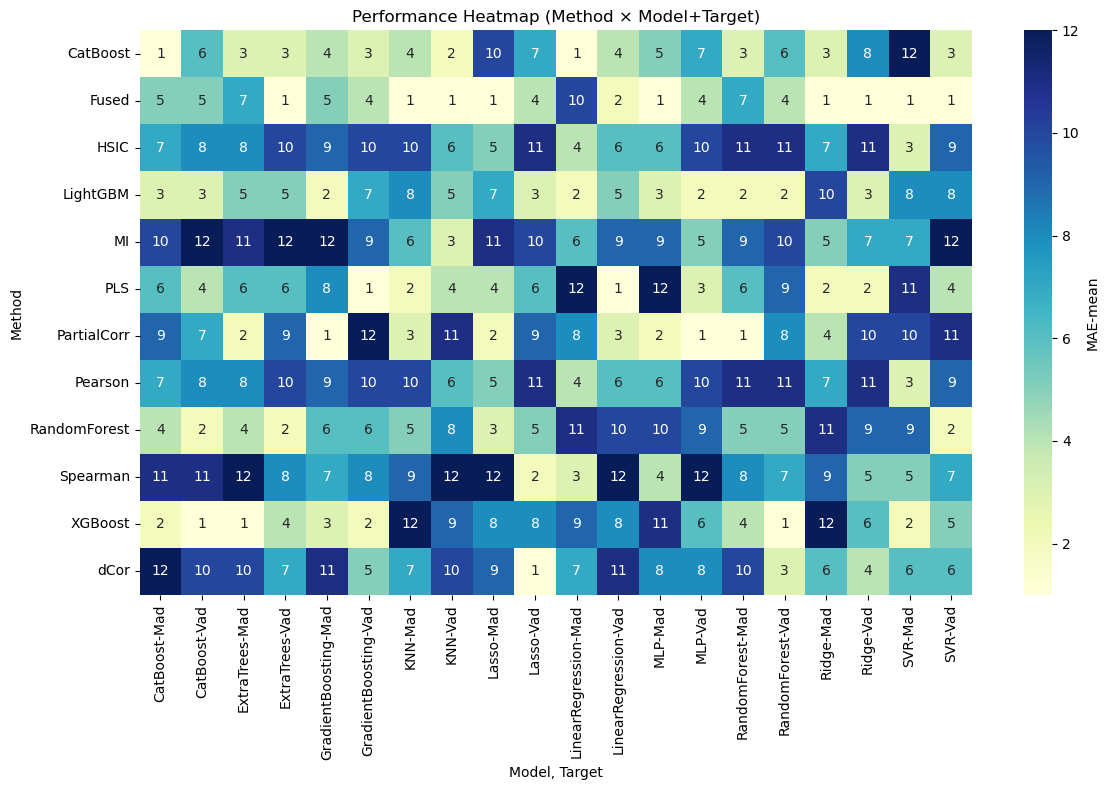


--- 使用指定顺序生成排序后的热力图 ---


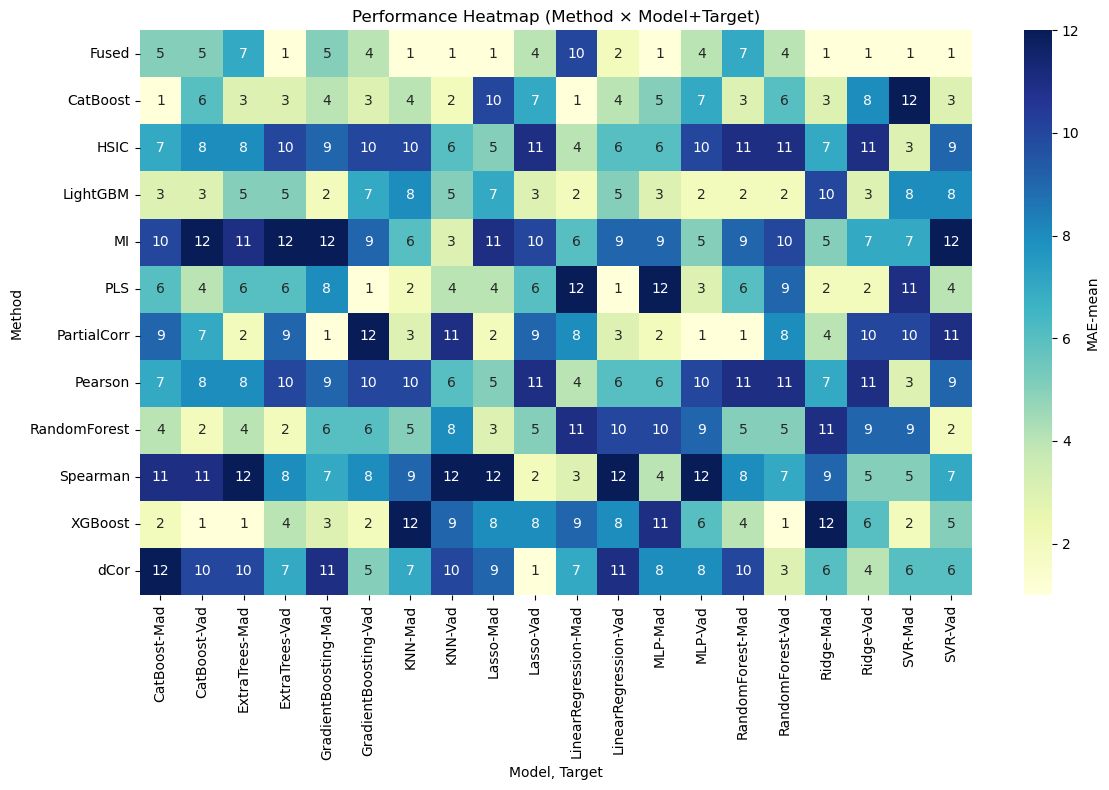


--- 生成箱线图 (按平均排名排序) ---


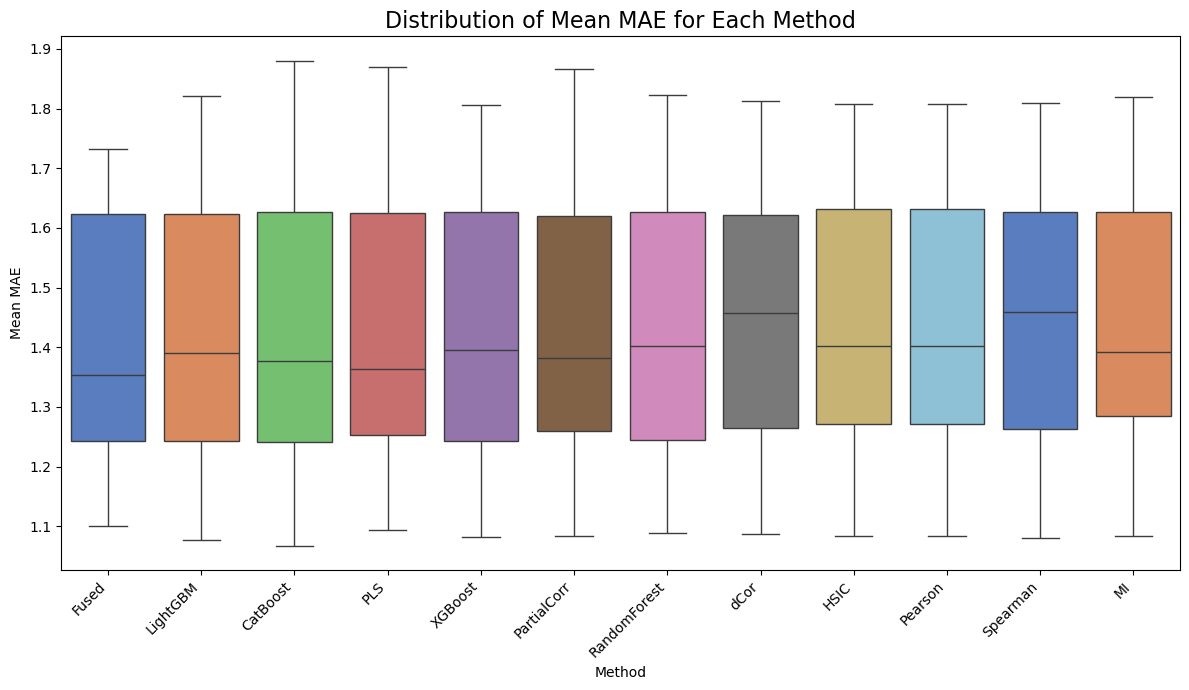


--- 生成雷达图（按每行归一化） ---


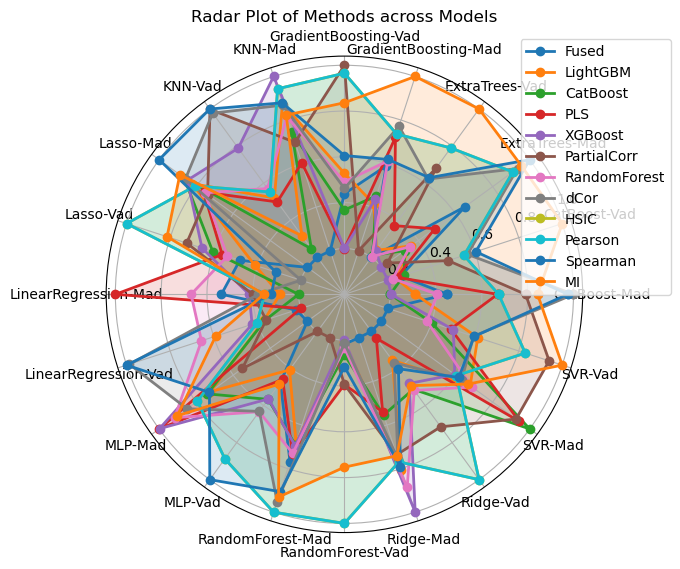

In [17]:

# =======================
# 方法在不同模型上的表现可视化（heatmap/bar/box/radar）
# =======================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_methods(pivot_df, plot_type="heatmap"):
    """
    可视化方法在不同模型上的表现
    pivot_df: 行是 (Model, Target)，列是 Method
    plot_type: "heatmap", "bar", "box", "radar"
    """

    # 把透视表变成长表
    df_reset = pivot_df.reset_index().melt(
        id_vars=["Model", "Target"],
        var_name="Method",
        value_name="MAE-mean"
    )

    if plot_type == "heatmap":
        plt.figure(figsize=(12, 8))
        sns.heatmap(
            pivot_df.T,  # 转置，横轴是Model，纵轴是Method
            annot=True, fmt="d", cmap="YlGnBu",
            cbar_kws={'label': 'MAE-mean'}
        )
        plt.title("Performance Heatmap (Method × Model+Target)")
        plt.xlabel("Model, Target")
        plt.ylabel("Method")
        plt.tight_layout()
        plt.show()

    elif plot_type == "bar":
        plt.figure(figsize=(12, 6))
        sns.barplot(
            data=df_reset,
            x="Model", y="MAE-mean", hue="Method"
        )
        plt.title("Comparison of Methods across Models")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # 其他 plot_type 保持不变...
    elif plot_type == "box":
        plt.figure(figsize=(12, 7))
        sns.boxplot(data=df_reset, x="Method", y="MAE-mean", palette="muted")
        plt.title("Distribution of Mean MAE for Each Method", fontsize=16)
        plt.xticks(rotation=45, ha="right")
        plt.ylabel("Mean MAE")
        plt.tight_layout()
        plt.show()

    # elif plot_type == "box":
    #     plt.figure(figsize=(10, 6))
    #     sns.boxplot(data=df_reset, x="Model", y="MAE-mean", hue="Method")
    #     plt.title("Distribution of MAE across Models for each Method")
    #     plt.xticks(rotation=45)
    #     plt.tight_layout()
    #     plt.show()

    elif plot_type == "radar":
        methods = pivot_df.columns
        models = pivot_df.index

        angles = np.linspace(0, 2 * np.pi, len(models), endpoint=False).tolist()
        angles += angles[:1]  # 闭合角度

        plt.figure(figsize=(7, 7))
        ax = plt.subplot(111, polar=True)

        for method in methods:
            values = pivot_df[method].values
            values = np.concatenate((values, [values[0]]))  # 闭合
            ax.plot(angles, values, "o-", linewidth=2, label=method)
            ax.fill(angles, values, alpha=0.15)

        ax.set_xticks(angles[:-1])
        ax.set_xticklabels([f"{m}-{t}" for m, t in models], rotation=30)
        plt.title("Radar Plot of Methods across Models")
        plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.05))
        plt.tight_layout()
        plt.show()

    else:
        raise ValueError("plot_type 必须是 'heatmap', 'bar', 'box', 'radar' 之一")

def rescale_per_model(pivot_df, lower=0.2, upper=1.0):
    """
    针对每个 Model-Target 行做 min-max 归一化，并设置下限 > 0
    """
    scaled = pivot_df.copy()
    for idx in scaled.index:
        row = scaled.loc[idx]
        rmin, rmax = row.min(), row.max()
        if rmax > rmin:
            scaled.loc[idx] = lower + (row - rmin) / (rmax - rmin) * (upper - lower)
        else:
            scaled.loc[idx] = (lower + upper) / 2  # 如果所有值一样
    return scaled

# 从 K 折平均结果构造透视表
combined_avg = pd.concat([mad_avg, vad_avg], ignore_index=True)
pivot_df = combined_avg.pivot_table(index=["Model", "Target"], columns="Method", values="MAE-mean")


# 根据指定顺序对方法列进行排序，并补充箱线图与归一化雷达图
desired_order = [
    'Fused', 'CatBoost', 'HSIC', 'LightGBM', 'MI', 'PLS',
    'PartialCorr', 'Pearson', 'RandomForest', 'Spearman', 'XGBoost', 'dCor'
]


# 画排序热力图：越小越好，使用排名整数便于直观比较
pivot_rank = pivot_df.rank(axis=1, method="min", ascending=True).astype(int)
visualize_methods(pivot_rank, plot_type="heatmap")

# 过滤掉不存在的列，避免错误
existing_methods_in_order = [m for m in desired_order if m in pivot_rank.columns]
if len(existing_methods_in_order) == 0:
    existing_methods_in_order = list(pivot_rank.columns)

# 应用新的列顺序
pivot_rank_sorted = pivot_rank[existing_methods_in_order]
print("\n--- 使用指定顺序生成排序后的热力图 ---")
visualize_methods(pivot_rank_sorted, plot_type="heatmap")

# 按方法的平均排名排序后绘制箱线图（使用原始 MAE 值）
print("\n--- 生成箱线图 (按平均排名排序) ---")
method_avg_rank = pivot_rank_sorted.mean().sort_values()
box_df = pivot_df[method_avg_rank.index]
visualize_methods(box_df, plot_type="box")

# 生成归一化后的雷达图（先按每个 Model-Target 行做 min-max 归一化）
print("\n--- 生成雷达图（按每行归一化） ---")
radar_df = rescale_per_model(box_df, lower=0.2, upper=1.0)
visualize_methods(radar_df, plot_type="radar")


In [21]:
# =======================
# 导入必要的库
# =======================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os # 确保导入 os 库来处理文件路径

# =======================
# 修改后的核心绘图函数
# =======================
def visualize_methods(pivot_df, plot_type="heatmap", save_path=None):
    """
    可视化方法在不同模型上的表现，并选择性地保存图像。
    
    pivot_df: 行是 (Model, Target)，列是 Method
    plot_type: "heatmap", "bar", "box", "radar"
    save_path: (新增) 图像的完整保存路径。如果为None，则显示图像。
    """

    # 把透视表变成长表 (box plot 需要)
    df_reset = pivot_df.reset_index().melt(
        id_vars=["Model", "Target"],
        var_name="Method",
        value_name="Value" # 使用更通用的名字，因为可能是MAE也可能是Rank
    )

    # --- 根据 plot_type 创建对应的图形 ---
    if plot_type == "heatmap":
        plt.figure(figsize=(14, 10))
        sns.heatmap(
            pivot_df.T,  # 转置，横轴是Model+Target，纵轴是Method
            annot=True, fmt="d", cmap="YlGnBu", # 使用反转色谱，值越小颜色越深
            linewidths=.5, cbar_kws={'label': 'Rank'}
        )
        # plt.title("Performance Ranking Heatmap (Method vs. Model-Target)", fontsize=16)
        plt.xlabel("Model-Target Combination", fontsize=12)
        plt.ylabel("Method", fontsize=12)
        # 自动调整x轴标签的角度
        plt.xticks(rotation=45, ha='right')

    elif plot_type == "box":
        plt.figure(figsize=(12, 7))
        sns.boxplot(data=df_reset, x="Method", y="Value", palette="muted")
        plt.title("Distribution of MAE for Each Method", fontsize=16)
        plt.xticks(rotation=45, ha="right")
        plt.ylabel("Mean Absolute Error (MAE)")
        plt.xlabel("Method")
        
    elif plot_type == "radar":
        # 确保数据不是排名而是归一化的性能值
        methods = pivot_df.columns
        # 将 MultiIndex 转换为更简洁的字符串标签
        labels = [f"{idx[0]}_{idx[1]}" for idx in pivot_df.index]

        angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
        angles += angles[:1]  # 闭合角度

        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

        for method in methods:
            values = pivot_df[method].values.tolist()
            values += values[:1] # 闭合
            ax.plot(angles, values, linewidth=1.5, linestyle='solid', label=method)
            ax.fill(angles, values, alpha=0.1)

        ax.set_yticklabels([]) # 雷达图通常隐藏径向轴的数字标签
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(labels)
        plt.title("Normalized Performance Radar Chart", size=20, color="black", y=1.1)
        plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))

    else:
        # 如果提供了未实现的 plot_type，则报错
        raise ValueError("plot_type 必须是 'heatmap', 'box', 'radar' 之一")

    # --- 保存或显示图像 ---
    plt.tight_layout() # 调整布局防止标签重叠

    if save_path:
        # 确保保存图像的目录存在
        output_dir = os.path.dirname(save_path)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        # 保存图像，推荐使用 bbox_inches='tight' 来裁剪空白边缘
        plt.savefig(save_path, format="svg", bbox_inches='tight')
        print(f"✅ 图像已保存到: {save_path}")
        plt.close() # 关闭图形，释放内存
    else:
        plt.show() # 如果没有提供路径，则像原来一样显示图像

def rescale_per_model(pivot_df, lower=0.2, upper=1.0):
    """
    针对每个 Model-Target 行做 min-max 归一化 (越小的值越接近upper)
    """
    scaled = pivot_df.copy()
    for idx in scaled.index:
        row = scaled.loc[idx]
        rmin, rmax = row.min(), row.max()
        if rmax > rmin:
            # MAE越小越好，所以归一化时要反转，让最小值映射到upper
            scaled.loc[idx] = upper - (row - rmin) / (rmax - rmin) * (upper - lower)
        else:
            scaled.loc[idx] = (lower + upper) / 2
    return scaled

# =======================
# 主逻辑 / 调用部分
# =======================



combined_avg = pd.concat([mad_avg, vad_avg], ignore_index=True)
pivot_df = combined_avg.pivot_table(index=["Model", "Target"], columns="Method", values="MAE-mean")

# --- 定义图片保存的目录 ---
# 假设您的项目根目录有一个 output 文件夹
# output_base_dir = "output" 
image_output_dir = os.path.join(output_base_dir, "visualization_images")

# --- 调用绘图函数并传入保存路径 ---

# 1. 画排序热力图 (按指定方法顺序)
print("\n--- 1. 生成排序后的热力图 ---")
desired_order = [
    'Fused', 'CatBoost', 'HSIC', 'LightGBM', 'MI', 'PLS',
    'PartialCorr', 'Pearson', 'RandomForest', 'Spearman', 'XGBoost', 'dCor'
]
# 过滤掉原始数据中可能不存在的方法
existing_methods_in_order = [m for m in desired_order if m in pivot_df.columns]

pivot_rank = pivot_df.rank(axis=1, method="min", ascending=True).astype(int)
pivot_rank_sorted = pivot_rank[existing_methods_in_order]

visualize_methods(
    pivot_rank_sorted, 
    plot_type="heatmap",
    save_path=os.path.join(image_output_dir, "performance_rank_heatmap.svg")
)

# 2. 画箱线图 (按方法的平均排名排序)
print("\n--- 2. 生成箱线图 (按平均排名排序) ---")
method_avg_rank = pivot_rank_sorted.mean().sort_values()
# 使用原始的 MAE 数据来画箱线图，但列的顺序遵循平均排名
box_df_sorted = pivot_df[method_avg_rank.index] 

visualize_methods(
    box_df_sorted, 
    plot_type="box",
    save_path=os.path.join(image_output_dir, "mae_distribution_boxplot.svg")
)

# 3. 生成归一化后的雷达图 (同样使用按平均排名排序的顺序)
print("\n--- 3. 生成雷达图（按每行归一化） ---")
# 雷达图需要对原始MAE值归一化，而不是对排名归一化
radar_df = rescale_per_model(box_df_sorted, lower=0, upper=1.0) 

visualize_methods(
    radar_df, 
    plot_type="radar",
    save_path=os.path.join(image_output_dir, "normalized_performance_radar.svg")
)


--- 1. 生成排序后的热力图 ---
✅ 图像已保存到: integrated_outputs\visualization_images\performance_rank_heatmap.svg

--- 2. 生成箱线图 (按平均排名排序) ---
✅ 图像已保存到: integrated_outputs\visualization_images\mae_distribution_boxplot.svg

--- 3. 生成雷达图（按每行归一化） ---
✅ 图像已保存到: integrated_outputs\visualization_images\normalized_performance_radar.svg



======== 开始生成可视化图表 ========



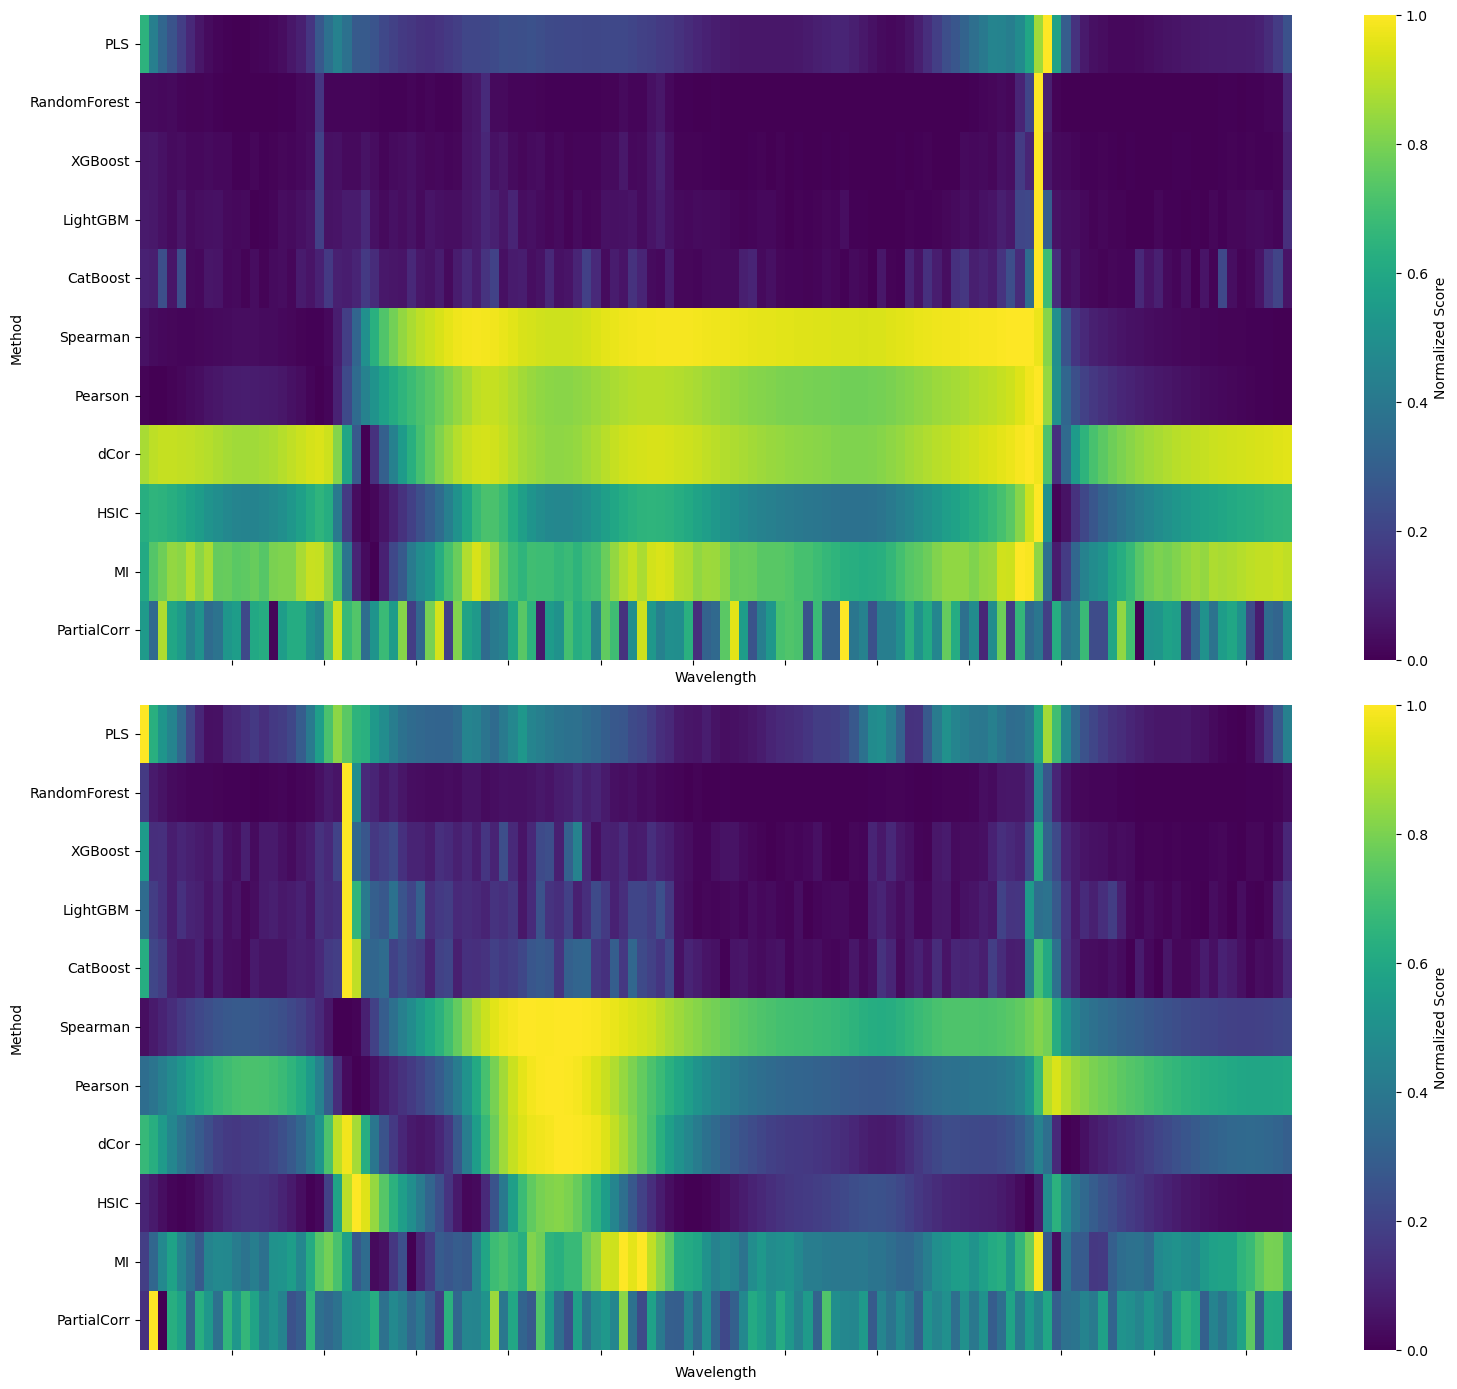

✅ 所有独立方法的热力图已保存到: integrated_outputs\visualization_images\individual_methods_heatmap.svg


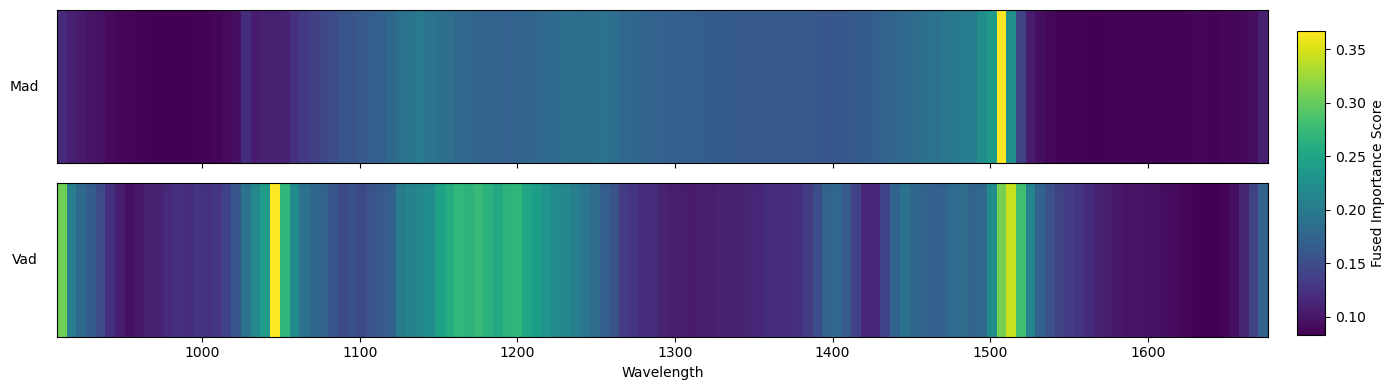

✅ 融合结果热力图已保存到: integrated_outputs\visualization_images\fused_results_heatmap.svg

======== 可视化图表生成完毕 ========



In [14]:

import matplotlib.ticker as mticker # 导入 ticker 模块
# ===============================================
# 3. 结果可视化 (新增部分)
# ===============================================
print("\n======== 开始生成可视化图表 ========\n")


# --- 把你的第二个代码包装成函数 ---
def plot_individual_method_heatmaps(base_dir, save_path):
    try:
        mad_scores_path = os.path.join(base_dir, "Mad", "Mad_all_scores.csv")
        vad_scores_path = os.path.join(base_dir, "Vad", "Vad_all_scores.csv")

        mad_df = pd.read_csv(mad_scores_path).set_index("Wavelength")
        vad_df = pd.read_csv(vad_scores_path).set_index("Wavelength")

        mad_df_norm = (mad_df - mad_df.min()) / (mad_df.max() - mad_df.min())
        vad_df_norm = (vad_df - vad_df.min()) / (vad_df.max() - vad_df.min())

        fig, axes = plt.subplots(2, 1, figsize=(16, 14), sharex=True)

        sns.heatmap(mad_df_norm.T, cmap="viridis", ax=axes[0], cbar_kws={'label': 'Normalized Score'})
        axes[0].set_ylabel("Method")

        sns.heatmap(vad_df_norm.T, cmap="viridis", ax=axes[1], cbar_kws={'label': 'Normalized Score'})
        axes[1].set_ylabel("Method")

        # --- 核心修改在这里 ---
        # 创建一个定位器，目标是最多显示 10-15 个刻度
        locator = mticker.MaxNLocator(nbins=15, prune='both') 
        axes[1].xaxis.set_major_locator(locator)
        # ----------------------

        plt.xlabel("Wavelength")
        plt.tight_layout()
        
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        # 确认已移除 dpi 参数
        # plt.savefig(save_path, format="svg", dpi=300)
        plt.savefig(save_path, format="svg") 
        plt.show()
        print(f"✅ 所有独立方法的热力图已保存到: {save_path}")

    except FileNotFoundError as e:
        print(f"错误: 找不到文件 {e.filename}。")
    except Exception as e:
        print(f"绘制独立方法热力图时发生错误: {e}")
# # --- 图 1: 所有独立特征选择方法的热力图 ---
# def plot_individual_method_heatmaps(base_dir, save_path):
#     """
#     绘制并保存Mad和Vad在所有独立方法下的重要性分数热力图。
#     """
#     try:
#         # 读取两个目标变量的分数数据
#         mad_scores_path = os.path.join(base_dir, "Mad", "Mad_all_scores.csv")
#         vad_scores_path = os.path.join(base_dir, "Vad", "Vad_all_scores.csv")

#         mad_df = pd.read_csv(mad_scores_path).set_index("Wavelength")
#         vad_df = pd.read_csv(vad_scores_path).set_index("Wavelength")

#         # 对每个方法分别进行min-max归一化以便于可视化
#         mad_df_norm = (mad_df - mad_df.min()) / (mad_df.max() - mad_df.min())
#         vad_df_norm = (vad_df - vad_df.min()) / (vad_df.max() - vad_df.min())

#         # 创建图形
#         fig, axes = plt.subplots(2, 1, figsize=(16, 14), sharex=True)

#         # 绘制MAD归一化分数热力图
#         sns.heatmap(mad_df_norm.T, cmap="viridis", ax=axes[0], cbar_kws={'label': 'Normalized Score'})
#         # axes[0].set_title("Heatmap of Individual Methods across Wavelengths (Mad)", fontsize=14)
#         axes[0].set_ylabel("Method")

#         # 绘制VAD归一化分数热力图
#         sns.heatmap(vad_df_norm.T, cmap="viridis", ax=axes[1], cbar_kws={'label': 'Normalized Score'})
#         # axes[1].set_title("Heatmap of Individual Methods across Wavelengths (Vad)", fontsize=14)
#         axes[1].set_ylabel("Method")

#         plt.xlabel("Wavelength")
#         plt.tight_layout()
        
#         # 确保保存目录存在
#         os.makedirs(os.path.dirname(save_path), exist_ok=True)
#         # plt.savefig(save_path, format="svg", dpi=300)
#         plt.savefig(save_path, format="svg")
#         plt.show()
#         print(f"✅ 所有独立方法的热力图已保存到: {save_path}")

#     except FileNotFoundError as e:
#         print(f"错误: 找不到文件 {e.filename}。请确保前面的步骤已成功运行并生成了对应的 .csv 文件。")
#     except Exception as e:
#         print(f"绘制独立方法热力图时发生错误: {e}")


# --- 图 2: 融合后结果的热力图 ---
def plot_fused_results_heatmap(base_dir, save_path):
    """
    绘制并保存Mad和Vad融合后的重要性分数的热力图。
    """
    try:
        # 读取两个融合后的得分文件
        dir_mad = os.path.join(base_dir, "Mad", "fused_results")
        dir_vad = os.path.join(base_dir, "Vad", "fused_results")
        
        df_mad = pd.read_csv(os.path.join(dir_mad, "scores_with_fused.csv"))
        df_vad = pd.read_csv(os.path.join(dir_vad, "scores_with_fused.csv"))

        wavelengths_mad = df_mad["Wavelength"].values
        fused_curve_mad = df_mad["Fused_Score"].values

        wavelengths_vad = df_vad["Wavelength"].values
        fused_curve_vad = df_vad["Fused_Score"].values

        # 创建画布和子图
        fig, axes = plt.subplots(2, 1, figsize=(14, 4), sharex=True)

        # Mad 热力图（放上面）
        im1 = axes[0].imshow(
            fused_curve_mad.reshape(1, -1), aspect="auto", cmap="viridis",
            extent=[wavelengths_mad.min(), wavelengths_mad.max(), 0, 1]
        )
        axes[0].set_yticks([])
        axes[0].set_ylabel("Mad", rotation=0, labelpad=20, va='center')
        # axes[0].set_title("Fused Importance Heatmap")

        # Vad 热力图（放下面）
        im2 = axes[1].imshow(
            fused_curve_vad.reshape(1, -1), aspect="auto", cmap="viridis",
            extent=[wavelengths_vad.min(), wavelengths_vad.max(), 0, 1]
        )
        axes[1].set_yticks([])
        axes[1].set_ylabel("Vad", rotation=0, labelpad=20, va='center')
        axes[1].set_xlabel("Wavelength")

        # 自动排版，为右侧的 colorbar 留出空间
        plt.tight_layout(rect=[0, 0, 0.92, 1])

        # 在右侧单独添加一个共享的 colorbar 轴
        cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.76])
        fig.colorbar(im2, cax=cbar_ax, label="Fused Importance Score")
        
        # 确保保存目录存在
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, format="svg", dpi=300)
        plt.show()
        print(f"✅ 融合结果热力图已保存到: {save_path}")

    except FileNotFoundError as e:
        print(f"错误: 找不到文件 {e.filename}。请确保融合步骤已成功运行并生成了 'scores_with_fused.csv' 文件。")
    except Exception as e:
        print(f"绘制融合结果热力图时发生错误: {e}")


# --- 调用绘图函数 ---
# 定义图片保存的目录
image_output_dir = os.path.join(output_base_dir, "visualization_images")

# 绘制并保存第一张图
plot_individual_method_heatmaps(
    base_dir=output_base_dir,
    save_path=os.path.join(image_output_dir, "individual_methods_heatmap.svg")
)

# 绘制并保存第二张图
plot_fused_results_heatmap(
    base_dir=output_base_dir,
    save_path=os.path.join(image_output_dir, "fused_results_heatmap.svg")
)

print("\n======== 可视化图表生成完毕 ========\n")

✅ 已保存两个文件和两张图片到: integrated_outputs\Mad\fused_results_for_stacked
✅ 已保存两个文件和两张图片到: integrated_outputs\Vad\fused_results_for_stacked


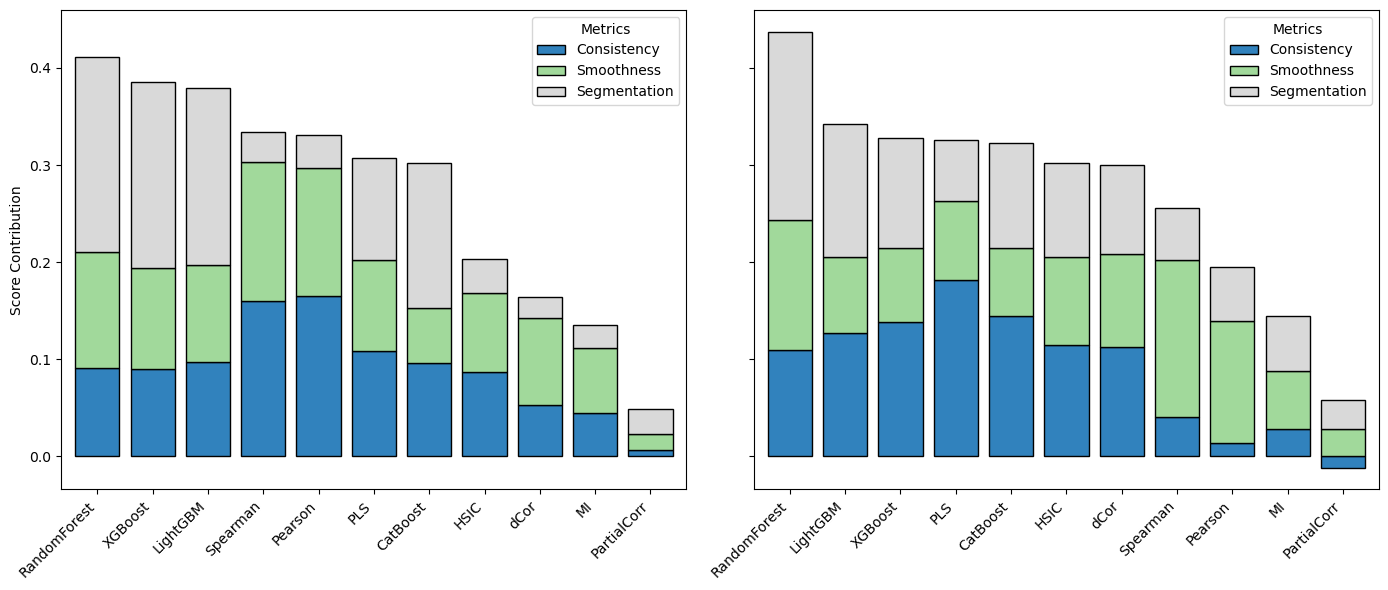

✅ 已保存两个文件和两张图片到: integrated_outputs\Mad\fused_results_for_stacked
✅ 已保存两个文件和两张图片到: integrated_outputs\Vad\fused_results_for_stacked


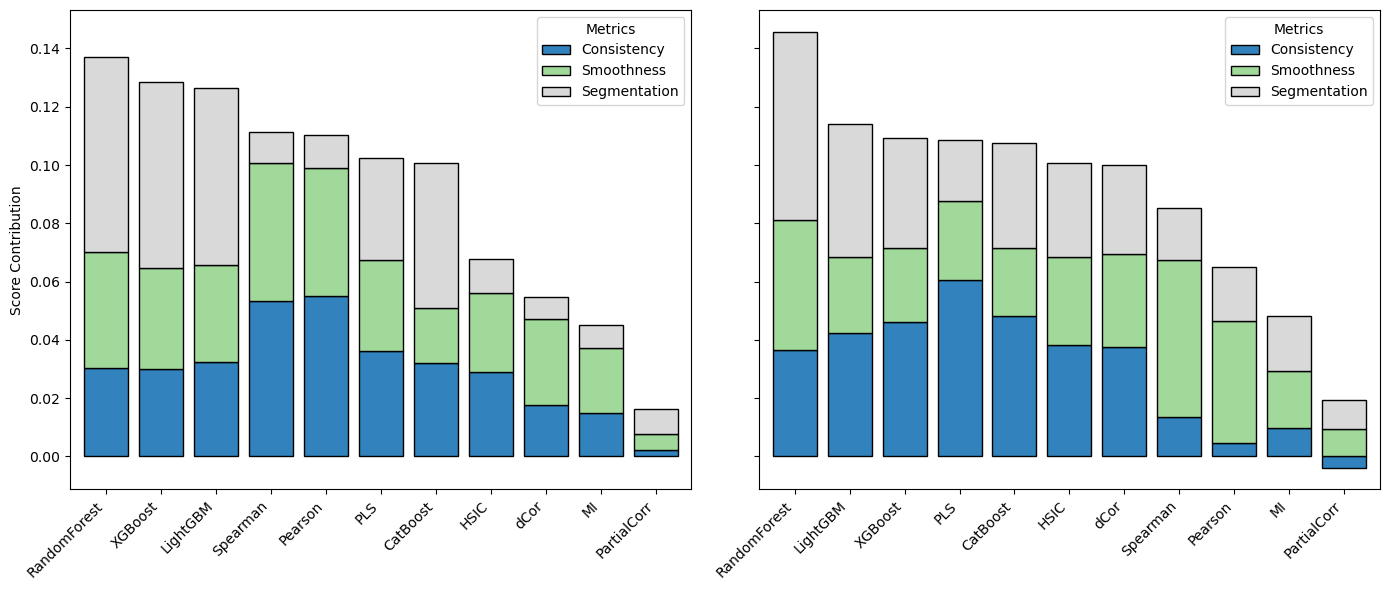

In [11]:

# =========================
# 仅绘制 M_ad & V_ad 堆叠柱状图（左右子图）
# =========================
def plot_stacked_bars(mad_file, vad_file, window_size=10, save_path="stacked_results.svg", weighted=False):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)  # 横向两个子图

    # Target 显示映射
    target_labels = {
        "Mad": r"$M_{ad}$",
        "Vad": r"$V_{ad}$",
    }

    def load_scores_and_ranks(scores_path):
        # 读取 scores.csv，如果不存在则抛错
        df_scores = pd.read_csv(scores_path)
        if "Wavelength" not in df_scores.columns:
            raise ValueError(f"文件 {scores_path} 缺少 'Wavelength' 列")
        methods = [c for c in df_scores.columns if c != "Wavelength"]
        # 派生 ranks（每个方法列按分数降序排名）
        ranks_dict = {"Wavelength": df_scores["Wavelength"].values}
        for m in methods:
            ranks_dict[f"{m}_Rank"] = pd.Series(df_scores[m]).rank(ascending=False, method="min").astype(int)
        df_ranks = pd.DataFrame(ranks_dict)
        return df_scores, df_ranks

    for ax, file, title in zip(
        axes,
        [mad_file, vad_file],
        ["Mad", "Vad"]
    ):
        try:
            df_scores, df_ranks = load_scores_and_ranks(file)
            # 评估融合指标（使用现有 evaluate_methods 接口）
            out_dir = os.path.join(output_base_dir, title, "fused_results_for_stacked")
            scores_out, ranks_out, results_df, fused_curve, wavelengths = evaluate_methods(
                df_scores, df_ranks, window_size=window_size, output_dir=out_dir
            )

            # 重命名列（NMF_Weight -> Consistency）
            results_df = results_df.rename(columns={"NMF_Weight": "Consistency"})
            # 根据 weighted 标志决定是否对三个指标进行加权
            if weighted:
                if {"Weight_Consistency", "Weight_Smoothness", "Weight_Segmentation"}.issubset(results_df.columns):
                    results_df["Consistency"] = results_df["Consistency"] * results_df["Weight_Consistency"]
                    results_df["Smoothness"] = results_df["Smoothness"] * results_df["Weight_Smoothness"]
                    results_df["Segmentation"] = results_df["Segmentation"] * results_df["Weight_Segmentation"]
                else:
                    print("提示：未检测到动态权重列，堆叠图将退化为未加权显示。")
            
            metrics = ["Consistency", "Smoothness", "Segmentation"]
            # 按 Final_Weight 排序（方法层面）
            plot_df = results_df.sort_values("Final_Weight", ascending=False)[metrics]

            # 堆叠柱状图
            plot_df.plot(
                kind="bar",
                stacked=True,
                ax=ax,
                colormap="tab20c",
                width=0.8,
                edgecolor="black"
            )

            ax.set_ylabel("Score Contribution")
            # if weighted:
            #     ax.set_title(f"Weighted Stacked Bar of Method Scores ({target_labels[title]})")
            # else:
            #     ax.set_title(f"Stacked Bar of Method Scores ({target_labels[title]})")
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
            ax.legend(title="Metrics")
        except FileNotFoundError as e:
            ax.set_title(f"文件缺失: {e.filename}")
            ax.text(0.5, 0.5, f"缺少文件\n{e.filename}", ha="center", va="center")
        except Exception as e:
            ax.set_title("绘图错误")
            ax.text(0.5, 0.5, f"错误: {e}", ha="center", va="center")

    plt.tight_layout()
    # 保存为 SVG
    os.makedirs(os.path.dirname(save_path) if os.path.dirname(save_path) else ".", exist_ok=True)
    plt.savefig(save_path, format="svg")
    plt.show()


# 使用示例（未加权堆叠）
plot_stacked_bars(
    os.path.join(output_base_dir, "Mad", "Mad_all_scores.csv"),
    os.path.join(output_base_dir, "Vad", "Vad_all_scores.csv"),
    save_path=os.path.join(output_base_dir, "visualization_images", "stacked_results_unweighted.svg"),
    weighted=False
)

# 使用示例（加权堆叠）
plot_stacked_bars(
    os.path.join(output_base_dir, "Mad", "Mad_all_scores.csv"),
    os.path.join(output_base_dir, "Vad", "Vad_all_scores.csv"),
    save_path=os.path.join(output_base_dir, "visualization_images", "stacked_results_weighted.svg"),
    weighted=True
)

In [ ]:

# ===============================================
# 追加：从 K 折平均结果 CSV 生成 LaTeX 表（基于 MAE-mean）
# 输出路径：integrated_outputs/prediction_results_kfold/prediction_mae_mean_table.tex
# 高亮规则：每个模型（行）在各方法（列）中，最小 MAE 加粗，次小 MAE 下划线
# ===============================================
def generate_latex_table_from_mean_csv(mad_csv_path, vad_csv_path, output_tex_path, decimals=3):
    import pandas as pd
    import numpy as np

    # 读取 CSV（只使用 MAE-mean 列）
    mad_df = pd.read_csv(mad_csv_path)
    vad_df = pd.read_csv(vad_csv_path)

    # 透视为 [行: 模型, 列: 方法] 的矩阵，值为 MAE-mean
    mad_pivot = mad_df.pivot_table(index="Model", columns="Method", values="MAE-mean", aggfunc="mean")
    vad_pivot = vad_df.pivot_table(index="Model", columns="Method", values="MAE-mean", aggfunc="mean")

    # 方法显示名映射（与论文表格常用缩写对齐）
    method_display_map = {
        "Fused": "Fused",
        "CatBoost": "CB",
        "HSIC": "HSIC",
        "LightGBM": "LGBM",
        "MI": "MI",
        "PLS": "PLS",
        "PartialCorr": "PCor",
        "Pearson": "PCC",
        "RandomForest": "RF",
        "Spearman": "SRC",
        "XGBoost": "XGB",
        "dCor": "dCor",
    }

    preferred_order = [
        "Fused", "CatBoost", "HSIC", "LightGBM", "MI", "PLS",
        "PartialCorr", "Pearson", "RandomForest", "Spearman", "XGBoost", "dCor",
    ]

    def order_columns(cols):
        present = [c for c in preferred_order if c in cols]
        # 追加其它在 CSV 中出现但不在预设顺序里的方法
        extras = [c for c in cols if c not in present]
        return present + sorted(extras)

    # 对齐两张表的列顺序（方法）
    all_methods = sorted(set(mad_pivot.columns).union(set(vad_pivot.columns)), key=lambda x: preferred_order.index(x) if x in preferred_order else 999)
    mad_pivot = mad_pivot.reindex(columns=order_columns(all_methods))
    vad_pivot = vad_pivot.reindex(columns=order_columns(all_methods))

    # LaTeX 格式化辅助函数
    def fmt(v):
        if pd.isna(v):
            return "-"
        return f"{float(v):.{decimals}f}"

    def highlight_row(values):
        # values: numpy array，可能包含 NaN
        numeric = values[~np.isnan(values)]
        if numeric.size == 0:
            return set(), set()
        # 找最小与次小（考虑并列）
        unique_sorted = np.unique(np.round(numeric.astype(float), decimals+2))  # 细粒度避免浮点误差
        best = unique_sorted[0]
        second = unique_sorted[1] if unique_sorted.size > 1 else None
        # 标记位置（值相等视为并列）
        bold_idx = set(np.where(np.round(values.astype(float), decimals+2) == best)[0])
        underline_idx = set()
        if second is not None:
            underline_idx = set(np.where(np.round(values.astype(float), decimals+2) == second)[0])
        # 避免同时加粗和下划线（并列第一优先加粗）
        underline_idx -= bold_idx
        return bold_idx, underline_idx

    # 构造 LaTeX 表头
    display_cols = [method_display_map.get(c, c) for c in mad_pivot.columns]
    col_spec = "l|" + "c" * len(display_cols)
    lines = []
    lines.append("% Auto-generated from *_prediction_results_mean.csv (MAE-mean)")
    lines.append("\\begin{tabular}{" + col_spec + "}")
    lines.append("\\hline")
    lines.append("Model & " + " & ".join(display_cols) + " \\\")
    lines.append("\\hline")

    # 写入 Mad 区块
    lines.append("\\multicolumn{" + str(len(display_cols)+1) + "}{l}{\\textbf{Mad}} \\\")
    for model in mad_pivot.index:
        row_vals = mad_pivot.loc[model].values.astype(float)
        bold_idx, underline_idx = highlight_row(row_vals.copy())
        cells = []
        for j, v in enumerate(row_vals):
            s = fmt(v)
            if j in bold_idx and s != "-":
                s = "\\textbf{" + s + "}"
            elif j in underline_idx and s != "-":
                s = "\\underline{" + s + "}"
            cells.append(s)
        lines.append(model + " & " + " & ".join(cells) + " \\\")

    lines.append("\\hline")

    # 写入 Vad 区块
    lines.append("\\multicolumn{" + str(len(display_cols)+1) + "}{l}{\\textbf{Vad}} \\\")
    for model in vad_pivot.index:
        row_vals = vad_pivot.loc[model].values.astype(float)
        bold_idx, underline_idx = highlight_row(row_vals.copy())
        cells = []
        for j, v in enumerate(row_vals):
            s = fmt(v)
            if j in bold_idx and s != "-":
                s = "\\textbf{" + s + "}"
            elif j in underline_idx and s != "-":
                s = "\\underline{" + s + "}"
            cells.append(s)
        lines.append(model + " & " + " & ".join(cells) + " \\\")

    lines.append("\\hline")
    lines.append("\\end{tabular}")

    # 写入文件
    with open(output_tex_path, "w", encoding="utf-8") as f:
        f.write("\n".join(lines))

    return output_tex_path


if __name__ == "__main__":
    # 在完整流程结束后，基于已保存的 mean CSV 生成 LaTeX 表
    try:
        agg_dir = os.path.join(output_base_dir, "prediction_results_kfold")
        mad_csv = os.path.join(agg_dir, "mad_prediction_results_mean.csv")
        vad_csv = os.path.join(agg_dir, "vad_prediction_results_mean.csv")
        tex_out = os.path.join(agg_dir, "prediction_mae_mean_table.tex")
        out_path = generate_latex_table_from_mean_csv(mad_csv, vad_csv, tex_out, decimals=3)
        print(f"✅ 已生成 LaTeX 表: {out_path}")
    except Exception as e:
        print(f"⚠️ 生成 LaTeX 表失败: {e}")

SyntaxError: EOL while scanning string literal (3272842061.py, line 81)